We create a `LocalCluster` here for convenience, so we can use the `get_client()` call
to get a client, from which we can see the Dask dashboard.

In [1]:
import dask
import dask.array as da
from dask.distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46843,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.26 GiB
Comm: tcp://127.0.0.1:41029,Total threads: 3
Dashboard: http://127.0.0.1:46153/status,Memory: 7.82 GiB
Nanny: tcp://127.0.0.1:43613,


[Dask](https://docs.dask.org/en/stable/) is designed to take large workloads
that are too large to compute in one go (e.g. do not fit in memery) and break
them up into manageable chunks.  The workload could be represented in several different
ways: as Arrays, Dataframes, or collections of Delayed function calls. Once the
workload is split up it usually exposes parallelism -- Dask will manage
dependencies between the operations on the chunks.

For example
let's look at Arrays.
We'll make a large Dask Array.  Note that no values are assigned yet, everything is delayed.

In [9]:
size = 40000
x = da.random.random((size, size), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(40000, 40000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

We can perform Numpy like functions on this array, it exposes many of the `ndarray` methods. Note still nothing is actually
being computed!

In [10]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z

dask.array<mean_agg-aggregate, shape=(20000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

To get the result we call `.compute()` on our Array to start the computation. This will wait until the computation
is complete, then return an `ndarray` containing the results. The calculation is done chunk by chunk, each chunk is
sent to the workers (in this case threads on a local machine) to be calculated.

In [11]:
z.compute()

array([0.99836089, 0.99840643, 0.99969969, ..., 1.00113066, 1.00215219,
       0.99957704], shape=(20000,))

The actual steps needed to do the transpose, addition, slicing, and mean calculations on each chunk, then recombine
those chunks into the final answer are all worked out by Dask.  We can see the steps it's doing by using
`.visualize()`. This is called the task graph.

In [5]:
z.visualize()

If the workload doesn't fit neatly into Array (`numpy.ndarray`-like) or Dataframe (`pandas.Dataframe`-like)
we can just use arbitrary blobs of delayed data as returned by some function.

Define a function that is decorated with `@dask.delayed` and when it is run it will return a Delayed object
representing that function's return. We can then pass this Delayed object into other functions, and so on.
We can also use undecorated functions by calling `dask.delayed(funcname)(func_args)`.

In [6]:
@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def double(x):
    return x * 2

@dask.delayed
def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = dask.delayed(sum)(output)
total

Delayed('sum-557be42d-f50c-4928-b6a1-91ec231ceb9d')

This also has a task graph.

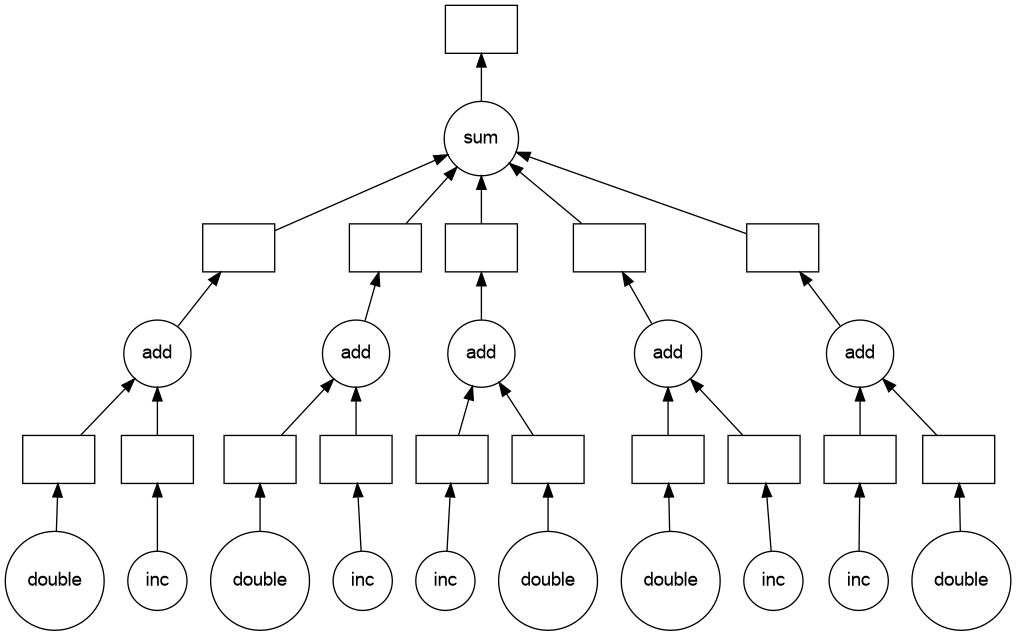

In [7]:
total.visualize()

We get the result using `.compute()` as before

In [8]:
total.compute()

50